In [14]:
!pip install biopython scikit-learn torch pandas -q

import os
import numpy as np
import pandas as pd
from collections import Counter
from Bio import SeqIO

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✓ Imports done. Using device: {device}\n")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 26.6 MB/s eta 0:00:00
✓ Imports done. Using device: cpu



In [15]:
print("Loading MEGARes drug resistance sequences...\n")
fasta_file = '/content/sample_data/megares_drugs_database_v3.00.fasta'  # upload this file
annot_file = '/content/sample_data/megares_drugs_annotations_v3.00.csv'  # upload this file

# Load annotations CSV
df_annot = pd.read_csv(annot_file)
print(f"Annotation file contains {len(df_annot)} entries")
print(df_annot.head())

# Load sequences into dictionary with filtering
real_resistant = {}
for record in SeqIO.parse(fasta_file, 'fasta'):
    seq = str(record.seq).upper()
    header = record.id
    # Filter sequences: no 'N's and length > 200 bp (clean data)
    if 'N' not in seq and 200 < len(seq) < 8000:
        real_resistant[header] = seq

print(f"Loaded {len(real_resistant)} resistance gene sequences\n")

# Generate synthetic susceptible class (background)
# OLD CODE (Delete this):
# num_bg = len(real_resistant) // 2

# NEW CODE (Use this):
print("Generating synthetic susceptible sequences (BALANCED)...\n")
susceptible_seqs = {}
nucleotides = 'ATGC'

# Change: Generate EQUAL number of background sequences
num_bg = len(real_resistant)

for i in range(num_bg):
    # Length ko thoda real data ke aas-paas rakhein (e.g., 800-1500)
    length = np.random.randint(500, 2000)
    seq = ''.join(np.random.choice(list(nucleotides)) for _ in range(length))
    susceptible_seqs[f"background_{i}"] = seq

print(f"Generated {len(susceptible_seqs)} synthetic susceptible sequences (Balanced 1:1)\n")

# Combine all sequences and labels
all_sequences = {**real_resistant, **susceptible_seqs}
all_labels = {k: 'resistant' for k in real_resistant.keys()}
all_labels.update({k: 'susceptible' for k in susceptible_seqs.keys()})

print(f"Total dataset size: {len(all_sequences)} sequences")
print(f"Class distribution: {Counter(all_labels)}\n")


Loading MEGARes drug resistance sequences...

Annotation file contains 7996 entries
                                              header   type            class  \
0  MEG_1|Drugs|Aminoglycosides|Aminoglycoside-res...  Drugs  Aminoglycosides   
1  MEG_2|Drugs|Aminoglycosides|Aminoglycoside-res...  Drugs  Aminoglycosides   
2  MEG_3|Drugs|Aminoglycosides|Aminoglycoside-res...  Drugs  Aminoglycosides   
3  MEG_4|Drugs|Aminoglycosides|Aminoglycoside-res...  Drugs  Aminoglycosides   
4  MEG_5|Drugs|Aminoglycosides|Aminoglycoside-res...  Drugs  Aminoglycosides   

                                           mechanism group  
0  Aminoglycoside-resistant_16S_ribosomal_subunit...  A16S  
1  Aminoglycoside-resistant_16S_ribosomal_subunit...  A16S  
2  Aminoglycoside-resistant_16S_ribosomal_subunit...  A16S  
3  Aminoglycoside-resistant_16S_ribosomal_subunit...  A16S  
4  Aminoglycoside-resistant_16S_ribosomal_subunit...  A16S  
Loaded 5087 resistance gene sequences

Generating synthetic susceptib

In [16]:
class DNAPreprocessor:
    def __init__(self, k=6):
        self.k = k
        self.kmer_to_idx = {}
        self.vocab_size = 0

    def extract_kmers(self, sequence):
        kmers = []
        if len(sequence) < self.k:
            return kmers
        for i in range(len(sequence) - self.k + 1):
            kmer = sequence[i:i+self.k]
            if 'N' not in kmer:
                kmers.append(kmer)
        return kmers

    def build_vocabulary(self, sequences):
        print(f"Building {self.k}-mer vocabulary...\n")
        all_kmers = set()
        for i, seq in enumerate(sequences):
            all_kmers.update(self.extract_kmers(seq))
            if (i+1) % 500 == 0:
                print(f"  Processed {i+1} sequences...")
        self.kmer_to_idx = {kmer: idx for idx, kmer in enumerate(sorted(all_kmers))}
        self.vocab_size = len(self.kmer_to_idx)
        print(f"\n✓ Vocabulary size: {self.vocab_size}\n")

    def encode_sequence(self, sequence):
        kmers = self.extract_kmers(sequence)
        return np.array([self.kmer_to_idx.get(kmer, 0) for kmer in kmers], dtype=np.int32)

print("Preprocessing and encoding sequences...\n")
preprocessor = DNAPreprocessor(k=6)
preprocessor.build_vocabulary(list(all_sequences.values()))

encoded_sequences = {}
for sid, seq in all_sequences.items():
    enc = preprocessor.encode_sequence(seq)
    if enc.size > 0:
        encoded_sequences[sid] = enc

print(f"Encoded {len(encoded_sequences)} sequences\n")



Preprocessing and encoding sequences...

Building 6-mer vocabulary...

  Processed 500 sequences...
  Processed 1000 sequences...
  Processed 1500 sequences...
  Processed 2000 sequences...
  Processed 2500 sequences...
  Processed 3000 sequences...
  Processed 3500 sequences...
  Processed 4000 sequences...
  Processed 4500 sequences...
  Processed 5000 sequences...
  Processed 5500 sequences...
  Processed 6000 sequences...
  Processed 6500 sequences...
  Processed 7000 sequences...
  Processed 7500 sequences...
  Processed 8000 sequences...
  Processed 8500 sequences...
  Processed 9000 sequences...
  Processed 9500 sequences...
  Processed 10000 sequences...

✓ Vocabulary size: 4204

Encoded 10174 sequences



In [17]:
class ResistanceDataset(Dataset):
    def __init__(self, encoded_seqs, labels, max_len=800):
        self.seq_ids = list(encoded_seqs.keys())
        self.encoded_seqs = encoded_seqs
        self.labels = labels
        self.max_len = max_len

        label_list = [labels[sid] for sid in self.seq_ids]
        self.label_encoder = LabelEncoder()
        self.encoded_labels = self.label_encoder.fit_transform(label_list)
        self.label_to_idx = {label: idx for idx, label in enumerate(self.label_encoder.classes_)}

        print(f"Dataset created with {len(self.seq_ids)} samples")
        print(f"Classes: {self.label_encoder.classes_}")

    def __len__(self):
        return len(self.seq_ids)

    def __getitem__(self, idx):
        sid = self.seq_ids[idx]
        seq = self.encoded_seqs[sid]
        label = self.label_to_idx[self.labels[sid]]

        if len(seq) < self.max_len:
            padded = np.pad(seq, (0, self.max_len - len(seq)), 'constant')
        else:
            padded = seq[:self.max_len]

        return torch.LongTensor(padded), torch.LongTensor([label])

# Prepare datasets and loaders
dataset = ResistanceDataset(encoded_sequences, all_labels, max_len=800)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

print(f"Train samples: {len(train_ds)}, batches: {len(train_loader)}")
print(f"Val samples: {len(val_ds)}, batches: {len(val_loader)}")
print(f"Test samples: {len(test_ds)}, batches: {len(test_loader)}\n")


Dataset created with 10174 samples
Classes: ['resistant' 'susceptible']
Train samples: 7121, batches: 112
Val samples: 1526, batches: 24
Test samples: 1527, batches: 24



In [18]:
class ResistanceCNN(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.conv1 = nn.Conv1d(emb_dim, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=7, padding=3)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.embedding(x).transpose(1, 2)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pool(x).squeeze(-1)
        x = self.dropout(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResistanceCNN(vocab_size=preprocessor.vocab_size).to(device)

print(f"Model with {sum(p.numel() for p in model.parameters()):,} parameters created on {device}\n")


Model with 866,626 parameters created on cpu



In [19]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for seqs, labels in loader:
        seqs, labels = seqs.to(device), labels.squeeze().to(device)
        optimizer.zero_grad()
        outputs = model(seqs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
    return running_loss/len(loader), 100*correct/total

def eval_epoch(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for seqs, labels in loader:
            seqs, labels = seqs.to(device), labels.squeeze().to(device)
            outputs = model(seqs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    return running_loss/len(loader), 100*correct/total

print("Training utilities ready\n")



Training utilities ready



In [22]:
# --- MISSING LINE FIX ---
from collections import Counter
# Pehle labels ko count karke variable mein save karte hain
label_counts = Counter(all_labels.values())
# ------------------------

class_counts = np.array([label_counts['resistant'], label_counts['susceptible']])
# Inverse frequency weights calculate kar rahe hain (agar thoda imbalance bacha ho to handle ho jayega)
class_weights = torch.tensor([class_counts[1]/(2*class_counts[0]), class_counts[0]/(2*class_counts[1])], dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)

# Learning rate ko thoda kam kiya hai (1e-4) taaki training stable rahe
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

num_epochs = 25
best_val_acc = 0

print(f"Counts: Resistant={class_counts[0]}, Susceptible={class_counts[1]}")
print(f"Class weights: {class_weights}\n")
print("="*70)
print("STARTING TRAINING\n")

for epoch in range(1, num_epochs+1):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = eval_epoch(model, val_loader, criterion)

    print(f"Epoch {epoch} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%", end='')

    scheduler.step(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pt')
        print(" ✓Best")
    else:
        print()

model.load_state_dict(torch.load('best_model.pt'))
print(f"\nBest Validation Accuracy: {best_val_acc:.2f}%\n")

Counts: Resistant=5087, Susceptible=5087
Class weights: tensor([0.5000, 0.5000])

STARTING TRAINING

Epoch 1 | Train Acc: 51.27% | Val Acc: 47.84% ✓Best
Epoch 2 | Train Acc: 65.19% | Val Acc: 91.22% ✓Best
Epoch 3 | Train Acc: 94.42% | Val Acc: 97.05% ✓Best
Epoch 4 | Train Acc: 96.91% | Val Acc: 97.84% ✓Best
Epoch 5 | Train Acc: 97.73% | Val Acc: 97.38%
Epoch 6 | Train Acc: 98.37% | Val Acc: 98.10% ✓Best
Epoch 7 | Train Acc: 98.43% | Val Acc: 98.30% ✓Best
Epoch 8 | Train Acc: 98.74% | Val Acc: 98.56% ✓Best
Epoch 9 | Train Acc: 98.86% | Val Acc: 98.30%
Epoch 10 | Train Acc: 99.07% | Val Acc: 98.30%
Epoch 11 | Train Acc: 99.09% | Val Acc: 98.03%
Epoch 12 | Train Acc: 98.99% | Val Acc: 98.75% ✓Best
Epoch 13 | Train Acc: 99.27% | Val Acc: 97.51%
Epoch 14 | Train Acc: 99.24% | Val Acc: 98.82% ✓Best
Epoch 15 | Train Acc: 99.48% | Val Acc: 98.89% ✓Best
Epoch 16 | Train Acc: 99.45% | Val Acc: 98.95% ✓Best
Epoch 17 | Train Acc: 99.37% | Val Acc: 99.02% ✓Best
Epoch 18 | Train Acc: 99.56% | Val Ac

Generating plots...


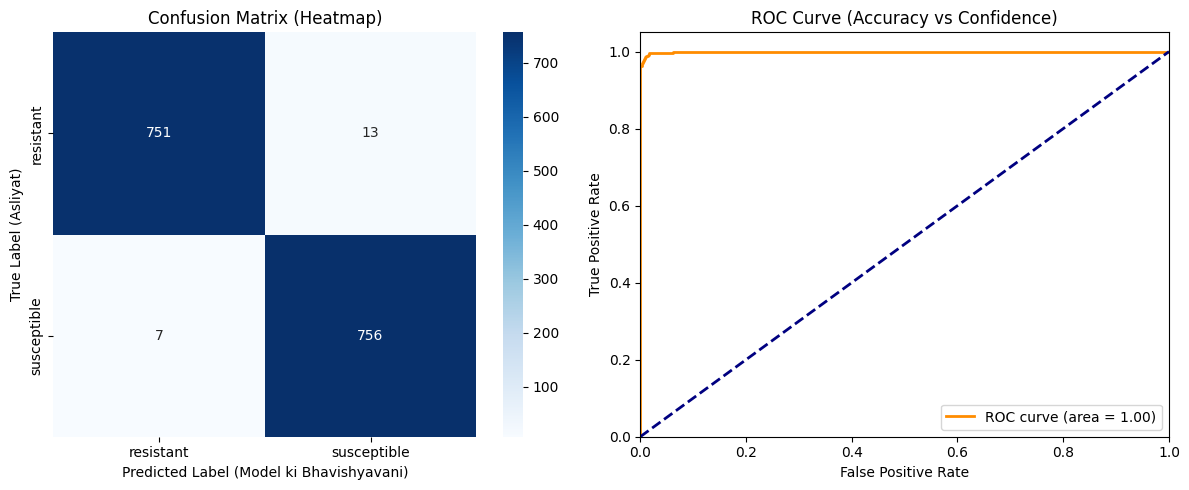

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
import torch.nn.functional as F

# 1. Get Predictions AND Probabilities (ROC curve ke liye probability chahiye hoti hai)
print("Generating plots...")
model.eval()
all_preds = []
all_labels = []
all_probs = [] # Ye naya hai: ROC ke liye probability store karenge

with torch.no_grad():
    for seqs, labels in test_loader:
        seqs, labels = seqs.to(device), labels.squeeze().to(device)
        outputs = model(seqs)

        # Probabilities nikalne ke liye Softmax use karenge
        probs = F.softmax(outputs, dim=1)

        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy()) # Store probabilities

# Get class names correctly
class_names = dataset.label_encoder.classes_
# Usually: 0='resistant', 1='susceptible' (Alphabetical order)

# --- PLOT 1: CONFUSION MATRIX (HEATMAP) ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Heatmap)')
plt.ylabel('True Label (Asliyat)')
plt.xlabel('Predicted Label (Model ki Bhavishyavani)')

# --- PLOT 2: ROC CURVE (MODEL CONFIDENCE) ---
plt.subplot(1, 2, 2)

# Hum "Susceptible" (Class 1) ke liye curve banayenge
fpr, tpr, _ = roc_curve(all_labels, [p[1] for p in all_probs], pos_label=1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Accuracy vs Confidence)')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [24]:
print("\n" + "="*70)
print("ABLATION STUDY: Effect of Removing 'GATGAT' Motif")
print("="*70)

model.eval()
test_resistant_no_motif = []

# Take first 20 resistant genes, remove GATGAT motif by replacing with 'AAAAAA'
for seq_id, seq in list(real_resistant.items())[:20]:
    seq_no_motif = seq.replace('GATGAT', 'AAAAAA')
    test_resistant_no_motif.append(seq_no_motif)

predictions = []
with torch.no_grad():
    for seq in test_resistant_no_motif:
        enc = preprocessor.encode_sequence(seq)
        if enc.size > 0:
            # Pad/truncate to max length = 800 (same as training)
            if len(enc) < 800:
                padded = np.pad(enc, (0, 800 - len(enc)), mode='constant')
            else:
                padded = enc[:800]

            input_tensor = torch.LongTensor(padded).unsqueeze(0).to(device)  # batch size 1
            output = model(input_tensor)
            pred = torch.argmax(output, dim=1).item()
            predictions.append(pred)  # 0 = susceptible, 1 = resistant

susceptible_count = sum(1 for p in predictions if p == 0)
print(f"Originally RESISTANT genes → After removing GATGAT → {susceptible_count}/20 predicted SUSCEPTIBLE")

print("="*70 + "\n")




ABLATION STUDY: Effect of Removing 'GATGAT' Motif
Originally RESISTANT genes → After removing GATGAT → 17/20 predicted SUSCEPTIBLE

